## 🧲 **Labor Market Tightness**

*Measures employer demand and labor force engagement*
**Frequency:** Monthly

| Indicator                                | Source              |
| ---------------------------------------- | ------------------- |
| Job Openings Rate                        | (`JTSJOL`)    |
| Hires Rate                               | (`JTSHIL`)    |
| Prime-Age Labor Force Participation Rate |(`LNS11300060`) |

In [2]:
import pandas as pd
import sqlite3

# Load CSV files into DataFrames
Job_Openings_Rate_df = pd.read_csv('Job_Openings_Rate.csv')
Hires_Rate_df = pd.read_csv('Hires_Rate.csv')
Prime_Labor_Force_Participation_Rate_df = pd.read_csv('Prime_Labor_Force_Participation_Rate.csv')
Unemployment_Level_df = pd.read_csv('Unemployment_Level.csv')



# Create an SQLite in-memory database
conn = sqlite3.connect(':memory:')

# Load DataFrames into the database as tables
Job_Openings_Rate_df.to_sql('Openings', conn, index=False, if_exists='replace')
Hires_Rate_df.to_sql('Hires', conn, index=False, if_exists='replace')
Prime_Labor_Force_Participation_Rate_df.to_sql('Prime_LFPR', conn, index=False, if_exists='replace')
Unemployment_Level_df.to_sql('Unemployed', conn, index=False, if_exists='replace')



# SQL query to merge all tables on 'Player'
sql_query = """
SELECT 
    Openings.observation_date, 
    JTSHIL AS "Job_Openings_Rate", 
    JTSJOL AS "Hires_Rate", 
    LNS11300060 AS "Prime_LFPR",
    Unemployed.UNEMPLOY AS "Unemployed"
FROM Openings
INNER JOIN Hires ON Openings.observation_date = Hires.observation_date
INNER JOIN Prime_LFPR ON Openings.observation_date = Prime_LFPR.observation_date
INNER JOIN Unemployed ON Openings.observation_date = Unemployed.observation_date
"""


# Execute the query and load results into a DataFrame
Labor_Market_Tightness_df = pd.read_sql_query(sql_query, conn)

# Save the merged DataFrame to a new CSV file
# csv_filename = "Stats/All_Player_Numbers.csv"
# Player_Numbers_df.to_csv(csv_filename, index=False)

# Close the connection
conn.close()

# Provide the file to the user


Labor_Market_Tightness_df

,observation_date,Job_Openings_Rate,Hires_Rate,Prime_LFPR,Unemployed
0,2000-12-01,5426,5088,83.9,5634
1,2001-01-01,5722,5234,84.1,6023
2,2001-02-01,5303,5097,84.1,6089
3,2001-03-01,5528,4762,84.1,6141
4,2001-04-01,5204,4615,83.7,6271
...,...,...,...,...,...
287,2024-11-01,5307,8031,83.5,7121
288,2024-12-01,5374,7508,83.4,6886
289,2025-01-01,5371,7762,83.5,6849
290,2025-02-01,5370,7480,83.5,7052


**Feature Engineering:**

* `OpeningsPerUnemployed = Job Openings / Unemployed`
* `OpeningsPerHire = Job Openings / Hires`
* `PrimeLFPR_Z = z-score(Prime-Age LFPR)`

In [3]:
from scipy.stats import zscore

Labor_Market_Tightness_df['Openings_Per_Unemployed'] = Labor_Market_Tightness_df['Job_Openings_Rate']/Labor_Market_Tightness_df['Unemployed']
Labor_Market_Tightness_df['Openings_Per_Hire'] = Labor_Market_Tightness_df['Job_Openings_Rate']/Labor_Market_Tightness_df['Hires_Rate']
Labor_Market_Tightness_df['Prime_LFPR_ZScore'] = zscore(Labor_Market_Tightness_df['Job_Openings_Rate'])
Labor_Market_Tightness_df = Labor_Market_Tightness_df.drop('Unemployed', axis=1)
Labor_Market_Tightness_df.columns

Index(['observation_date', 'Job_Openings_Rate', 'Hires_Rate', 'Prime_LFPR',
       'Openings_Per_Unemployed', 'Openings_Per_Hire', 'Prime_LFPR_ZScore'],
      dtype='object')

**Market Tightness Index (MTI)**

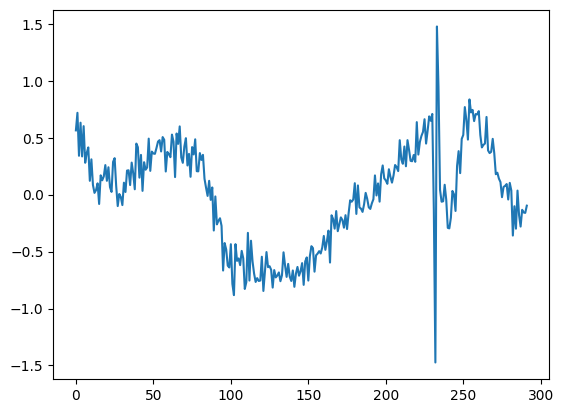

In [10]:
from scipy.stats import zscore

# Standardize manually if not already z-scored
Labor_Market_Tightness_df['OpeningsPerUnemployed_z'] = zscore(Labor_Market_Tightness_df['Openings_Per_Unemployed'], nan_policy='omit')
Labor_Market_Tightness_df['OpeningsPerHire_z'] = zscore(Labor_Market_Tightness_df['Openings_Per_Hire'], nan_policy='omit')
Labor_Market_Tightness_df['PrimeLFPR_z'] = Labor_Market_Tightness_df['Prime_LFPR_ZScore']  # Already z-scored

# Combine into index
Labor_Market_Tightness_df['Labor_Market_Tightness_Index'] = Labor_Market_Tightness_df[[
    'OpeningsPerUnemployed_z',
    'OpeningsPerHire_z',
    'PrimeLFPR_z'
]].mean(axis=1, skipna=True)


Labor_Market_Tightness_df['Labor_Market_Tightness_Index'].plot()


import os

os.makedirs('LMT', exist_ok=True)

Labor_Market_Tightness_df[['observation_date', 'Labor_Market_Tightness_Index']].to_csv(
    'Labor_Market_Tightness_Index.csv', index=False
)

import pandas as pd

# Load the original data
tight_df = pd.read_csv('Labor_Market_Tightness_Index.csv')
tight_df['observation_date'] = pd.to_datetime(tight_df['observation_date'])

# Automatically assign tightness labels using quantiles
tight_df['Tightness_Label'] = pd.qcut(
    tight_df['Labor_Market_Tightness_Index'],
    q=4,
    labels=['Strong_Supply', 'Balanced_Market', 'Strong_Demand', 'Overheated_Demand']
)

# ✅ Overwrite the original file with labels added
tight_df.to_csv('Labor_Market_Tightness_Index.csv', index=False)
